In [1]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from transformers import TrOCRProcessor, VisionEncoderDecoderModel

/Users/sergio/Documents/OCR_project/ocr_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

MODEL_DIR = "./trocr_notebooks_ft"  # <- ajusta si usaste otro path

processor = TrOCRProcessor.from_pretrained(MODEL_DIR)
model = VisionEncoderDecoderModel.from_pretrained(MODEL_DIR)

model.to(device)
model.eval()

def trocr_predict(image: Image.Image, max_length: int = 128) -> str:
    image = image.convert("RGB")
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

    with torch.no_grad():
        generated_ids = model.generate(pixel_values, max_length=max_length)

    text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return text.strip()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
def load_page_cv2(path: str, max_width: int = 1600):
    # cv2 carga en BGR
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        raise ValueError(f"No pude leer la imagen: {path}")
    h, w = img_bgr.shape[:2]

    # reescalar si es muy grande
    if w > max_width:
        new_h = int(h * max_width / w)
        img_bgr = cv2.resize(img_bgr, (max_width, new_h), interpolation=cv2.INTER_AREA)
    
    return img_bgr

def show_cv2(img_bgr, title=""):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

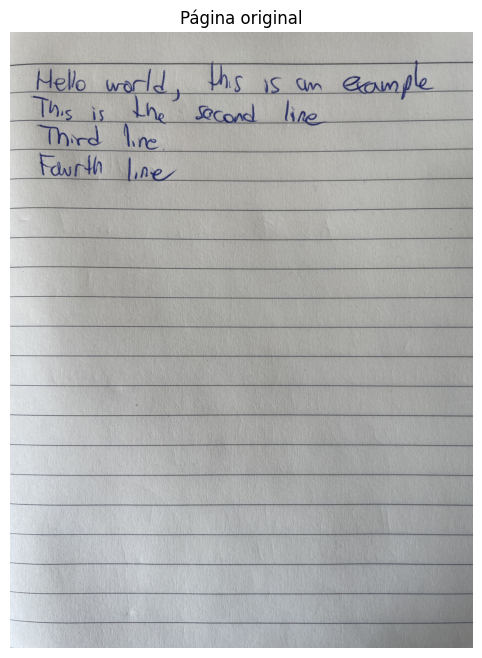

In [4]:
img_path = "data/personal_notes/IMG_7330.jpg"  # ajusta
page_bgr = load_page_cv2(img_path)
show_cv2(page_bgr, "Página original")

### Preprocesamiento de Lineas

In [ ]:
def detect_line_boxes(
    img_bgr,
    min_height_ratio=0.015,   # altura mínima relativa de una línea
    max_height_ratio=0.10,    # altura máxima relativa de una línea
    min_width_ratio=0.4,      # ancho mínimo relativo (líneas largas, no palabras)
    kernel_scale=25,          # controla el tamaño del kernel horizontal
    block_size=31,            # binarización adaptativa
    C=15,
    debug=False,
):
    """
    Devuelve bounding boxes de LÍNEAS (x, y, w, h) ordenadas de arriba hacia abajo.
    La idea es que capture líneas completas, no palabras sueltas.
    """
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # 1) Binarización adaptativa: texto blanco sobre negro
    thresh = cv2.adaptiveThreshold(
        blur,
        255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY_INV,
        block_size,
        C,
    )

    h, w = thresh.shape

    # 2) Kernel horizontal GRANDE para unir palabras en una sola línea
    kernel_width = max(30, w // kernel_scale)  # a menor kernel_scale, más grande el kernel
    horizontal_kernel = cv2.getStructuringElement(
        cv2.MORPH_RECT, (kernel_width, 3)
    )

    morphed = cv2.dilate(thresh, horizontal_kernel, iterations=1)
    morphed = cv2.erode(morphed, horizontal_kernel, iterations=1)

    # 3) Contornos externos (bloques de texto)
    contours, _ = cv2.findContours(
        morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    boxes = []
    for cnt in contours:
        x, y, bw, bh = cv2.boundingRect(cnt)

        # Altura relativa (filtrar ruido y bloques multi-renglón)
        if bh < min_height_ratio * h or bh > max_height_ratio * h:
            continue

        # Ancho relativo: queremos líneas largas, no “trozos” pequeños
        if bw < min_width_ratio * w:
            continue

        pad = 5
        x0 = max(0, x - pad)
        y0 = max(0, y - pad)
        x1 = min(w, x + bw + pad)
        y1 = min(h, y + bh + pad)

        boxes.append((x0, y0, x1 - x0, y1 - y0))

    # 4) Ordenar de arriba a abajo
    boxes = sorted(boxes, key=lambda b: b[1])

    if debug:
        dbg = img_bgr.copy()
        for (x, y, bw, bh) in boxes:
            cv2.rectangle(dbg, (x, y), (x + bw, y + bh), (0, 0, 255), 2)
        show_cv2(dbg, "Bounding boxes de LÍNEAS")

        plt.figure(figsize=(6, 6))
        plt.imshow(thresh, cmap="gray")
        plt.title("Máscara binarizada")
        plt.axis("off")
        plt.show()

    return boxes

In [ ]:
detect_line_boxes(page_bgr, debug=True)

In [ ]:
gray = cv2.cvtColor(page_bgr, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(blur)

In [ ]:
# 1) Binarización adaptativa: texto blanco sobre negro
C = 15
block_size = 31

thresh = cv2.adaptiveThreshold(
    blur,
    255,
    cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY_INV,
    block_size,
    C,
)
plt.imshow(thresh,cmap='gray')
thresh.shape

In [ ]:
h, w = thresh.shape
kernel_scale=25
kernel_width = max(30, w // kernel_scale)
horizontal_kernel = cv2.getStructuringElement(
        cv2.MORPH_RECT, (kernel_width, 3)
    )
morphed = cv2.dilate(thresh, horizontal_kernel, iterations=1)
morphed = cv2.erode(morphed, horizontal_kernel, iterations=1)
plt.imshow(morphed)

In [ ]:
min_height_ratio = 0.015
max_height_ratio = 0.1
min_width_ratio = 0.4
contours, _ = cv2.findContours(
        morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
boxes = []
for cnt in contours:
    x, y, bw, bh = cv2.boundingRect(cnt)

    # Altura relativa (filtrar ruido y bloques multi-renglón)
    if bh < min_height_ratio * h or bh > max_height_ratio * h:
        continue

    # Ancho relativo: queremos líneas largas, no “trozos” pequeños
    if bw < min_width_ratio * w:
        continue

    pad = 5
    x0 = max(0, x - pad)
    y0 = max(0, y - pad)
    x1 = min(w, x + bw + pad)
    y1 = min(h, y + bh + pad)

    boxes.append((x0, y0, x1 - x0, y1 - y0))
boxes = sorted(boxes, key=lambda b: b[1])

dbg = page_bgr.copy()
for (x, y, bw, bh) in boxes:
    cv2.rectangle(dbg, (x, y), (x + bw, y + bh), (0, 0, 255), 2)
show_cv2(dbg, "Bounding boxes de LÍNEAS")

plt.figure(figsize=(6, 6))
plt.imshow(thresh, cmap="gray")
plt.title("Máscara binarizada")
plt.axis("off")
plt.show()

### Detección de líneas por Bloque

In [5]:
def to_gray_and_blur(img_bgr, ksize=(5, 5)):
    """
    Convierte la imagen BGR a escala de grises y aplica un suavizado Gaussiano.
    """
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, ksize, 0)
    return gray

def binarize_page(gray, block_size=31, C=10):
    """
    Binarización adaptativa (texto + líneas del cuaderno en blanco = 255).
    Se devuelve la versión invertida (texto en 255 sobre fondo 0).
    """
    thr = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY_INV,
        block_size, C
    )
    return thr

def detect_rulings(thr, kernel_width=120):
    """
    Detecta las líneas horizontales largas (renglones) usando morfología.
    kernel_width define cuán largas deben ser las líneas detectadas.
    """
    kernel_rulings = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_width, 1))
    rulings = cv2.morphologyEx(thr, cv2.MORPH_OPEN, kernel_rulings, iterations=1)
    return rulings

def remove_rulings(thr, rulings, clean_kernel=(3, 3)):
    """
    Elimina las líneas detectadas del binario y limpia ruido pequeño.
    """
    thr_no_rulings = cv2.bitwise_and(thr, cv2.bitwise_not(rulings))

    kernel_small = cv2.getStructuringElement(cv2.MORPH_RECT, clean_kernel)
    thr_no_rulings = cv2.morphologyEx(thr_no_rulings, cv2.MORPH_OPEN, kernel_small, iterations=1)
    return thr_no_rulings

def connect_text_horizontally(thr_no_rulings, kernel_size=(40, 3)):
    """
    Une caracteres de una misma línea usando dilatación horizontal.
    Esto genera bandas continuas donde hay texto.
    """
    kernel_h = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    band_mask = cv2.dilate(thr_no_rulings, kernel_h, iterations=1)
    return band_mask

def refine_vertical_bounds(thr_no_rulings,
                           y0,
                           y1,
                           extra_ratio=0.5,
                           min_extra=15):
    """
    Refina los límites verticales (y0, y1) buscando exactamente
    dónde hay píxeles de texto en thr_no_rulings, y luego agrega
    un padding proporcional a la altura de la línea.

    extra_ratio: % de la altura de la línea que se añade por arriba y abajo.
    min_extra:  padding mínimo en píxeles.
    """
    h_total = thr_no_rulings.shape[0]

    # Recorte de la banda original
    band = thr_no_rulings[y0:y1, :]
    row_hist = np.sum(band > 0, axis=1)
    idx = np.where(row_hist > 0)[0]

    # Si no hay texto, devolvemos lo original
    if len(idx) == 0:
        return y0, y1

    # Donde realmente empiezan / terminan las letras
    top = y0 + int(idx[0])
    bottom = y0 + int(idx[-1])

    height = bottom - top + 1
    extra = max(int(height * extra_ratio), min_extra)

    y0_new = max(top - extra, 0)
    y1_new = min(bottom + extra, h_total - 1)

    return y0_new, y1_new

def get_line_spans_from_projection(band_mask, min_line_height=15):
    """
    A partir de la proyección horizontal (conteo de píxeles por fila),
    devuelve una lista de segmentos verticales (y0, y1) que contienen texto.
    """
    hist = np.sum(band_mask > 0, axis=1)

    # Umbral dinámico en función de la media y la desviación estándar
    row_mean = np.mean(hist)
    row_std = np.std(hist)
    row_thresh = row_mean + 0.5 * row_std

    is_text_row = hist > row_thresh

    line_spans = []
    in_run = False
    start = 0

    for y, flag in enumerate(is_text_row):
        if flag and not in_run:
            start = y
            in_run = True
        elif not flag and in_run:
            end = y
            if end - start >= min_line_height:
                line_spans.append((start, end))
            in_run = False

    # Si la imagen termina dentro de una banda
    if in_run:
        end = len(is_text_row)
        if end - start >= min_line_height:
            line_spans.append((start, end))

    return line_spans

def build_line_boxes(thr_no_rulings, line_spans,
                     density_thresh=0.02,
                     pad_x=5,
                     extra_y_ratio=0.5,
                     min_extra_y=15):
    """
    Para cada span vertical (y0, y1):
      - se refina el rango en Y usando thr_no_rulings
      - se calcula densidad de texto
      - se construye el bounding box (x0, y0_ref, x1, y1_ref) con padding en X
    """
    h, w = thr_no_rulings.shape
    boxes = []

    for (y0, y1) in line_spans:
        # 1) Refinar verticalmente en función del texto real
        y0_ref, y1_ref = refine_vertical_bounds(
            thr_no_rulings,
            y0,
            y1,
            extra_ratio=extra_y_ratio,
            min_extra=min_extra_y
        )

        # 2) Densidad de texto dentro del rango refinado
        band = thr_no_rulings[y0_ref:y1_ref, :]
        text_pixels = np.sum(band > 0)
        area = (y1_ref - y0_ref) * w
        density = text_pixels / float(area + 1e-6)
        if density < density_thresh:
            continue

        # 3) Bounding box horizontal
        col_hist = np.sum(band > 0, axis=0)
        cols = np.where(col_hist > 0)[0]
        if len(cols) == 0:
            continue

        x0 = int(cols[0])
        x1 = int(cols[-1])

        # Padding en X
        x0 = max(x0 - pad_x, 0)
        x1 = min(x1 + pad_x, w - 1)

        boxes.append((x0, y0_ref, x1, y1_ref))

    return boxes


In [6]:
def detect_lines_modular(img_bgr,
                            min_line_height=15,
                            density_thresh=0.02,
                            debug=False):
    
    gray = to_gray_and_blur(img_bgr)
    thr = binarize_page(gray)
    rulings = detect_rulings(thr)
    thr_no_rulings = remove_rulings(thr, rulings)
    band_mask = connect_text_horizontally(thr_no_rulings)
    line_spans = get_line_spans_from_projection(
            band_mask, min_line_height=min_line_height
        )
    boxes = build_line_boxes(
        thr_no_rulings,
        line_spans,
        density_thresh=density_thresh
    )   
    if debug:
        print("line_spans:", line_spans)
        print("boxes:", boxes)
        cv2.imwrite("debug_1_gray.png", gray)
        cv2.imwrite("debug_2_thr.png", thr)
        cv2.imwrite("debug_3_rulings.png", rulings)
        cv2.imwrite("debug_4_thr_no_rulings.png", thr_no_rulings)
        cv2.imwrite("debug_5_band_mask.png", band_mask)

    return boxes, thr, thr_no_rulings, band_mask

In [7]:
line_boxes, thr, thr_no_rulings, band_mask = detect_lines_modular(
    page_bgr,
    min_line_height=15,
    density_thresh=0.02,
    debug=True
)
vis = page_bgr.copy()
for (x0, y0, x1, y1) in line_boxes:
    cv2.rectangle(vis, (x0, y0), (x1, y1), (255, 0, 0), 2)

cv2.imwrite("lines_detected.png", vis)

line_spans: [(125, 213), (220, 314), (347, 395), (447, 502)]
boxes: [(0, 81, 1468, 256), (0, 173, 1468, 360), (88, 323, 1060, 418), (0, 420, 1230, 528)]


True

In [8]:
def trocr_predict_line(line_bgr, max_length=128):
    # cv2 BGR -> PIL RGB
    line_rgb = cv2.cvtColor(line_bgr, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(line_rgb)

    pixel_values = processor(images=pil_img, return_tensors="pt").pixel_values.to(device)

    model.eval()
    with torch.no_grad():
        generated_ids = model.generate(pixel_values, max_length=max_length)

    text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return text.strip()

Hello world , this is an example


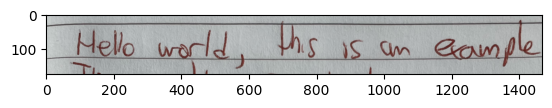

This is the second time


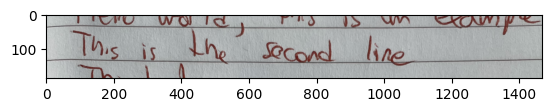

Mord line.


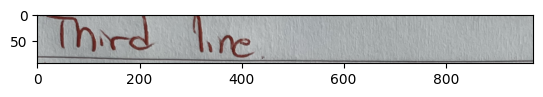

Fourth line


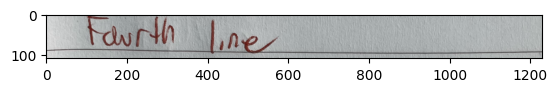

In [9]:
line_texts = []
for (x1, y1, x2, y2) in line_boxes:
    line_bgr = page_bgr[y1:y2, x1:x2]
    txt = trocr_predict_line(line_bgr)
    print(txt)
    plt.imshow(line_bgr)
    plt.show()